## Setup environment

In [3]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

## Setup imports

In [4]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.transforms import FillHoles, BoundingRect
import os
import tempfile
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset
from monai.losses import HoVerNetLoss
from monai.metrics import DiceMetric
from monai.networks.nets import HoVerNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    AsDiscreted,
    Compose,
    ScaleIntensityRanged,
    CastToTyped,
    Lambdad,
    SplitDimd,
    EnsureChannelFirstd,
    ComputeHoVerMapsd,
    FillHoles,
    BoundingRect,
)
from monai.apps.pathology.transforms.post.array import (
    GenerateInstanceCentroid, 
    GenerateInstanceContour, 
    GenerateInstanceType,
)
from monai.utils import set_determinism, convert_to_tensor, first
from monai.utils.enums import HoVerNetBranch
from sklearn.model_selection import StratifiedShuffleSplit

import torch

print_config()

MONAI version: 1.0.0+99.g919235ff.dirty
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+d321be6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 919235ffcba796c2b154fed3e34559dfd121e91f
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.14.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.21.3
mlflow version: 1.28.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Process dataset

In [7]:
def prepare_datasets(data_dir):
    info = pd.read_csv(os.path.join(data_dir, "patch_info.csv"))
    file_names = np.squeeze(info.to_numpy()).tolist()

    img_sources = [v.split("-")[0] for v in file_names]
    img_sources = np.unique(img_sources)

    cohort_sources = [v.split("_")[0] for v in img_sources]
    _, cohort_sources = np.unique(cohort_sources, return_inverse=True)

    splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=0)

    split_generator = splitter.split(img_sources, cohort_sources)
    for train_indices, valid_indices in split_generator:
        train_cohorts = img_sources[train_indices]
        valid_cohorts = img_sources[valid_indices]
        if np.intersect1d(train_cohorts, valid_cohorts).size != 0:
            raise ValueError("Train and validation cohorts has an overlap.")
        train_names = [
            file_name for file_name in file_names for source in train_cohorts if source == file_name.split("-")[0]
        ]
        valid_names = [
            file_name for file_name in file_names for source in valid_cohorts if source == file_name.split("-")[0]
        ]
        train_names = np.unique(train_names)
        valid_names = np.unique(valid_names)
        print(f"Train: {len(train_names):04d} - Valid: {len(valid_names):04d}")
        if np.intersect1d(train_names, valid_names).size != 0:
            raise ValueError("Train and validation cohorts has an overlap.")

        train_indices = [file_names.index(v) for v in train_names]
        valid_indices = [file_names.index(v) for v in valid_names]

    images = np.load(os.path.join(data_dir, "images.npy"))
    labels = np.load(os.path.join(data_dir, "labels.npy"))

    data = [
        {
            "image": image,
            "image_meta_dict": {"original_channel_dim": -1},
            "label": label,
            "label_meta_dict": {"original_channel_dim": -1},
        }
        for image, label in zip(images, labels)
    ]

    train_data = [data[i] for i in train_indices]
    valid_data = [data[i] for i in valid_indices]

    return train_data, valid_data

## Setup transforms for training and validation

In [8]:
def cropping_center(x, crop_shape, batch=False):
    """Crop an input image at the centre.
    Args:
        x: input array
        crop_shape: dimensions of cropped array

    Returns:
        x: cropped array

    """
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[1] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[2] - crop_shape[1]) * 0.5)
        x = x[:, h0: h0 + crop_shape[0], w0: w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[2] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[3] - crop_shape[1]) * 0.5)
        x = x[..., h0: h0 + crop_shape[0], w0: w0 + crop_shape[1]]
    return x

In [9]:
train_transforms = Compose(
    [
        EnsureChannelFirstd(keys=("image", "label"), channel_dim=-1),
        SplitDimd(keys="label", output_postfixes=["inst", "type"]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        Lambdad(keys="label", func=lambda x: x[1: 2, ...] > 0),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 7]),
        Lambdad(keys=["label", "label_inst", "label_type", "hover_label_inst"],
                func=lambda x: cropping_center(x, crop_shape=(164, 164))),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_transforms = Compose(
    [
        EnsureChannelFirstd(keys=("image", "label"), channel_dim=-1),
        SplitDimd(keys="label", output_postfixes=["inst", "type"]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        Lambdad(keys="label", func=lambda x: x[1: 2, ...] > 0),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 7]),
        Lambdad(keys=["label", "label_inst", "label_type", "hover_label_inst"],
                func=lambda x: cropping_center(x, crop_shape=(164, 164))),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)

## Define Dataset and DataLoader for training and validation

In [10]:
data_dir = os.path.join(root_dir, 'Lizard/Prepared')

train_data, valid_data = prepare_datasets(data_dir)
train_ds = Dataset(data=train_data, transform=train_transforms)
valid_ds = Dataset(data=valid_data, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=5, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=1, num_workers=4, pin_memory=True)

Train: 3900 - Valid: 1081


## Check first data shape and visualize

image: 
    shape (1, 3, 256, 256)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape (1, 2, 164, 164)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape (1, 2, 164, 164)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
train number of batches: 780
valid number of batches: 1081


Text(0.5, 1.0, 'vertical hover map')

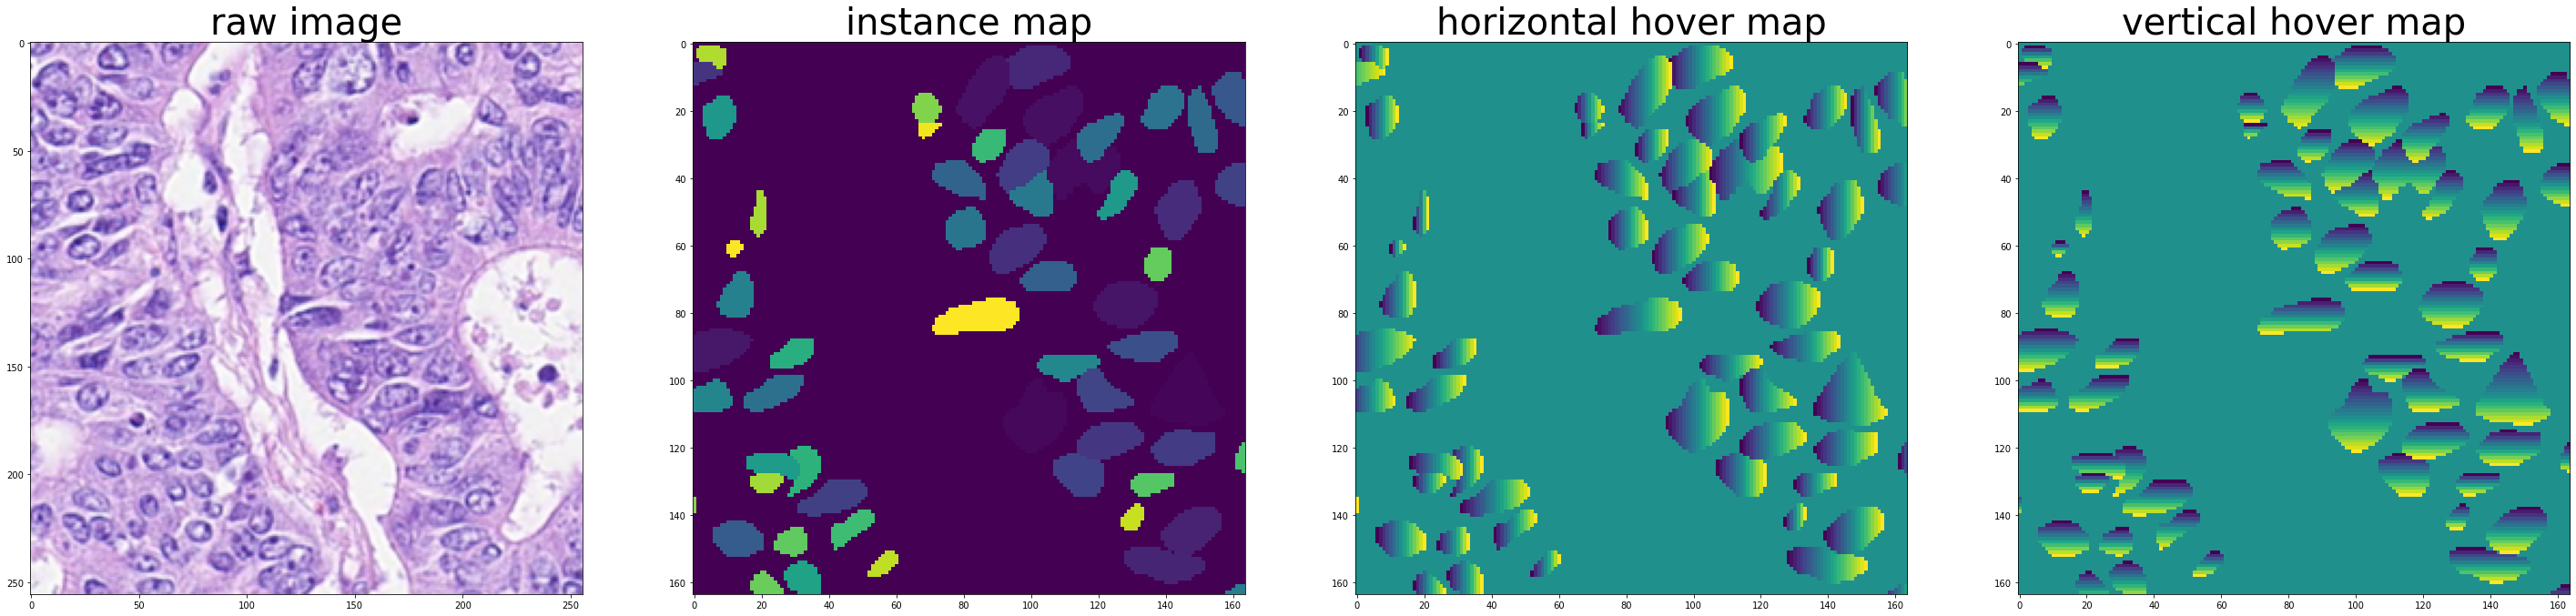

In [11]:
first_sample = first(val_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
print(f"train number of batches: {len(train_loader)}")
print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
ax[0].imshow((first_sample['image'][0, ...] * 255).astype(np.uint8).transpose(1, 2, 0))
ax[1].imshow(first_sample['label_inst'][0, ...].squeeze())
ax[2].imshow(first_sample['hover_label_inst'][0, 0, ...])
ax[3].imshow(first_sample['hover_label_inst'][0, 1, ...])
ax[0].set_title('raw image', fontsize=40)
ax[1].set_title('instance map', fontsize=40)
ax[2].set_title('horizontal hover map', fontsize=40)
ax[3].set_title('vertical hover map', fontsize=40)

## Create Model, Loss, Optimizer

In [12]:

device = torch.device("cuda:0")
model = HoVerNet(
    mode="fast",
    in_channels=3,
    out_classes=7,
    act=("relu", {"inplace": True}),
    norm="batch",
    dropout_prob=0.2,
).to(device)
loss_function = HoVerNetLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [11]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], []]
epoch_loss_values = []
metric_values = []

post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_label, val_label_type, val_hover_map = (
                    batch_data["image"].to(device),
                    batch_data["label"].to(device),
                    batch_data["label_type"].to(device),
                    batch_data["hover_label_inst"].to(device),
                )

                val_outputs = model(val_inputs)
                val_outputs = [post_pred(i['nucleus_prediction']) for i in decollate_batch(val_outputs)]
                val_label = [i for i in decollate_batch(val_label)]

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(data_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/600
epoch 1 average loss: 23.7731
time consuming of epoch 1 is: 1.5911
----------
epoch 2/600
epoch 2 average loss: 20.6329
saved new best metric model
current epoch: 2 current mean dice: 0.0146
best mean dice: 0.0146 at epoch: 2
time consuming of epoch 2 is: 2.3114
----------
epoch 3/600
epoch 3 average loss: 18.5050
time consuming of epoch 3 is: 1.0640
----------
epoch 4/600
epoch 4 average loss: 17.1777
saved new best metric model
current epoch: 4 current mean dice: 0.0185
best mean dice: 0.0185 at epoch: 4
time consuming of epoch 4 is: 2.2971
----------
epoch 5/600
epoch 5 average loss: 15.8279
time consuming of epoch 5 is: 1.0571
----------
epoch 6/600
epoch 6 average loss: 15.2240
current epoch: 6 current mean dice: 0.0103
best mean dice: 0.0185 at epoch: 4
time consuming of epoch 6 is: 2.1506
----------
epoch 7/600
epoch 7 average loss: 14.6849
time consuming of epoch 7 is: 1.0622
----------
epoch 8/600
epoch 8 average loss: 14.2148
saved new best metric model

epoch 61 average loss: 11.2634
time consuming of epoch 61 is: 1.0702
----------
epoch 62/600
epoch 62 average loss: 11.3037
saved new best metric model
current epoch: 62 current mean dice: 0.5403
best mean dice: 0.5403 at epoch: 62
time consuming of epoch 62 is: 2.3360
----------
epoch 63/600
epoch 63 average loss: 11.3649
time consuming of epoch 63 is: 1.0761
----------
epoch 64/600
epoch 64 average loss: 11.2435
saved new best metric model
current epoch: 64 current mean dice: 0.5415
best mean dice: 0.5415 at epoch: 64
time consuming of epoch 64 is: 2.3492
----------
epoch 65/600
epoch 65 average loss: 11.2758
time consuming of epoch 65 is: 1.0609
----------
epoch 66/600
epoch 66 average loss: 11.2320
current epoch: 66 current mean dice: 0.5339
best mean dice: 0.5415 at epoch: 64
time consuming of epoch 66 is: 2.1583
----------
epoch 67/600
epoch 67 average loss: 11.3825
time consuming of epoch 67 is: 1.0710
----------
epoch 68/600
epoch 68 average loss: 11.3023
saved new best metric 

epoch 121 average loss: 11.2540
time consuming of epoch 121 is: 1.0833
----------
epoch 122/600
epoch 122 average loss: 11.3353
current epoch: 122 current mean dice: 0.5454
best mean dice: 0.5505 at epoch: 82
time consuming of epoch 122 is: 2.1730
----------
epoch 123/600
epoch 123 average loss: 11.1827
time consuming of epoch 123 is: 1.0797
----------
epoch 124/600
epoch 124 average loss: 11.2566
current epoch: 124 current mean dice: 0.5448
best mean dice: 0.5505 at epoch: 82
time consuming of epoch 124 is: 2.1756
----------
epoch 125/600
epoch 125 average loss: 11.2966
time consuming of epoch 125 is: 1.0715
----------
epoch 126/600
epoch 126 average loss: 11.2854
current epoch: 126 current mean dice: 0.5441
best mean dice: 0.5505 at epoch: 82
time consuming of epoch 126 is: 2.1706
----------
epoch 127/600
epoch 127 average loss: 11.3056
time consuming of epoch 127 is: 1.0730
----------
epoch 128/600
epoch 128 average loss: 11.2297
current epoch: 128 current mean dice: 0.5470
best mea

KeyboardInterrupt: 

In [84]:

post_trans_seg = Compose([
    GenerateWatershedMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
    GenerateInstanceBorderd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=3),
    GenerateDistanceMapd(keys='mask', border_key='border', smooth_fn="gaussian"),
    GenerateWatershedMarkersd(keys='mask', border_key='border', threshold=0.7, radius=2, postprocess_fn=FillHoles()),
    Watershedd(keys='dist', mask_key='mask', markers_key='markers')
])


def post_process(output, return_centroids=True, output_classes=7):
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(output[HoVerNetBranch.NC.value])

    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']

    inst_id_list = np.unique(pred_inst)[1:]  # exclude background

    inst_info_dict = None
    if return_centroids:
        inst_id_list = np.unique(pred_inst)[1:]  # exclude background
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0]: inst_bbox[0][1], inst_bbox[0][2]: inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(
                bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob

    pred_inst = convert_to_tensor(pred_inst, device=device)
    return (pred_inst, inst_info_dict, pred_inst_dict)

## Check best model output with the input image and label

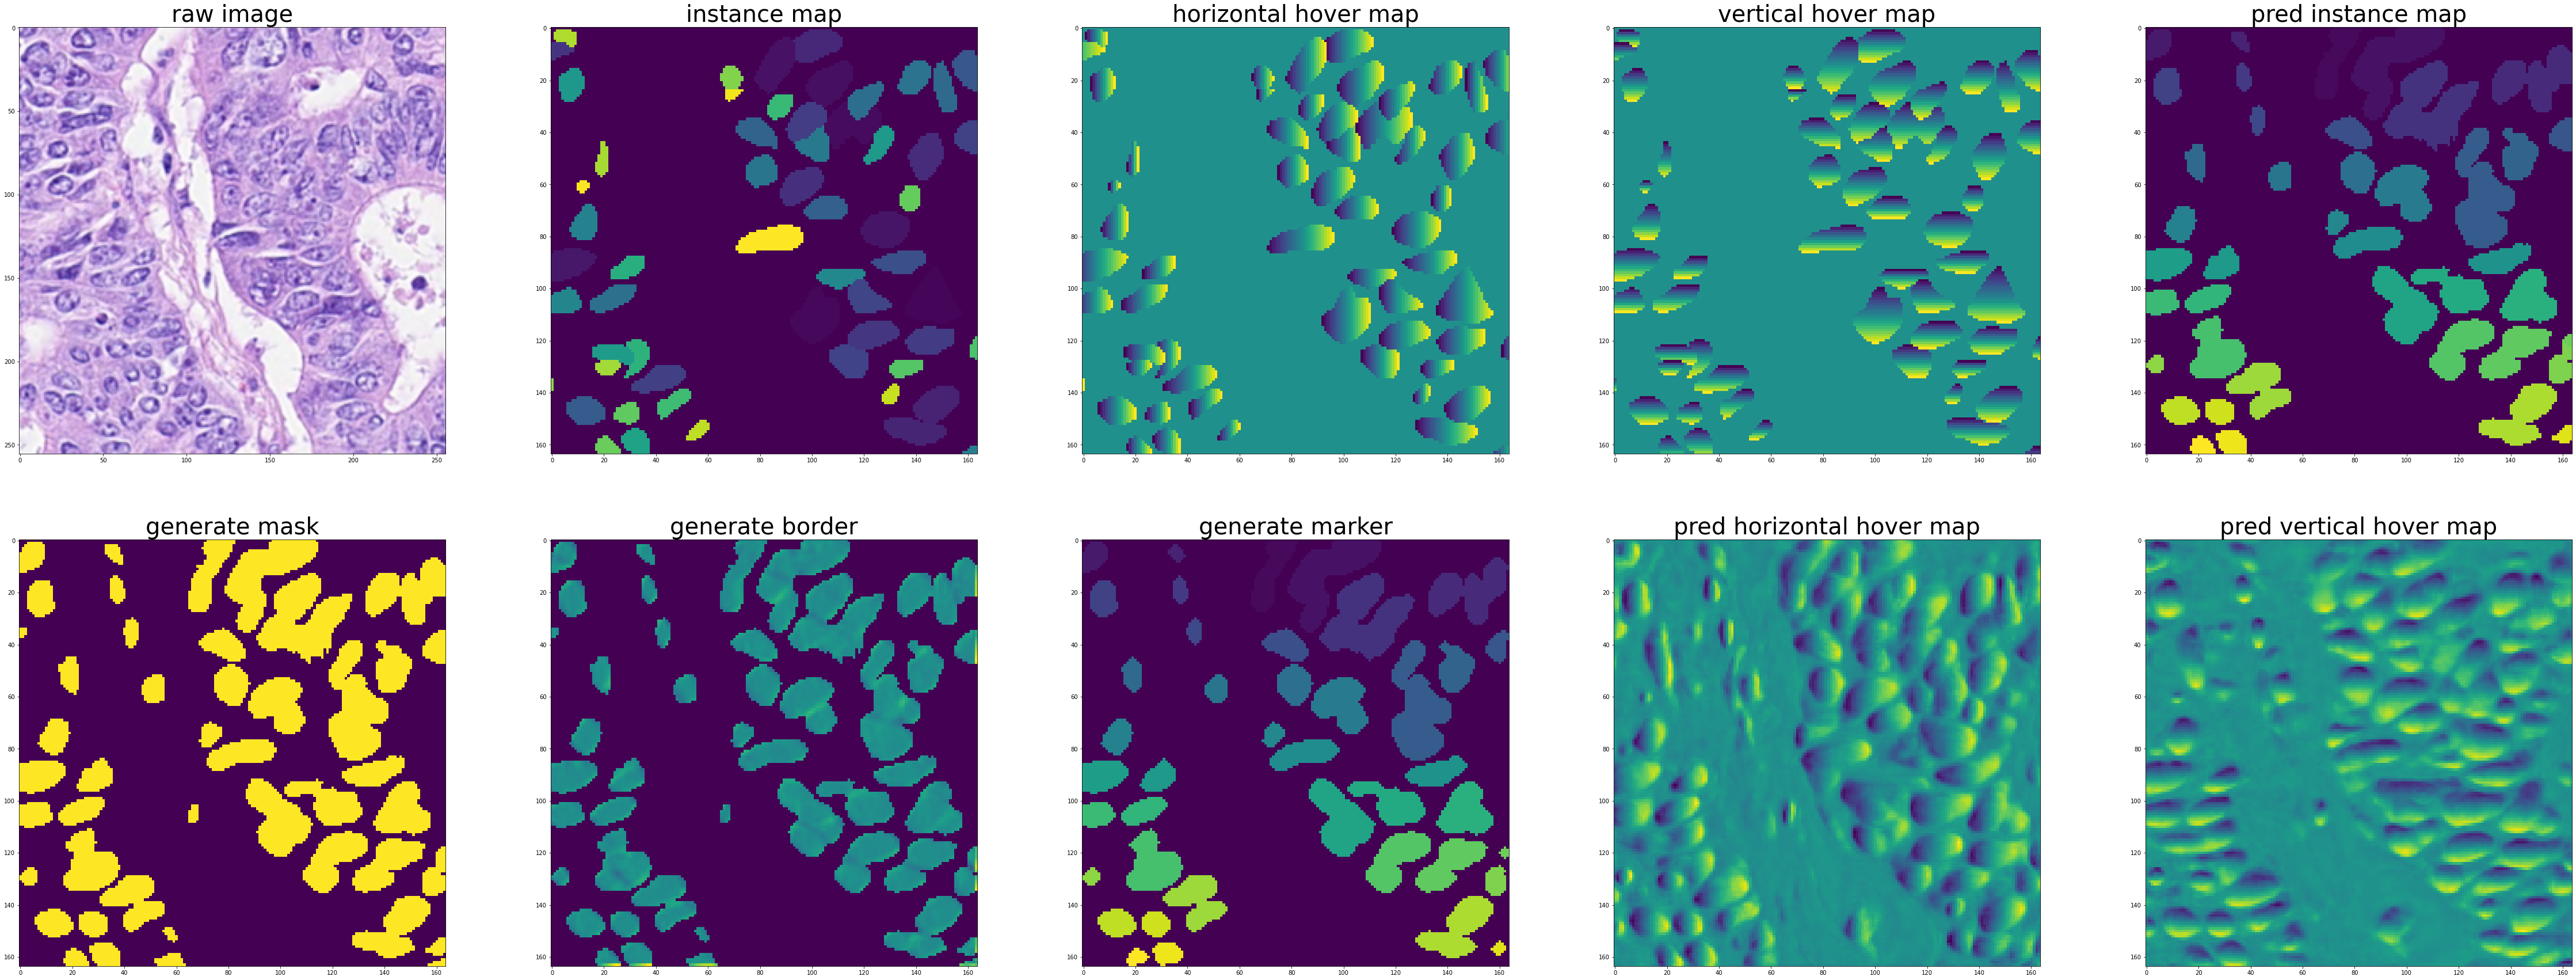

In [85]:
# test postprocess transform 
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = valid_ds[0]["image"].unsqueeze(0).to(device)

    val_output = model(val_input)
    val_output_ = [post_process(i) for i in decollate_batch(val_output)]

    fig, ax = plt.subplots(2, 5, figsize=(80, 30))
    ax[0, 0].imshow(val_input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
    ax[0, 1].imshow(valid_ds[0]["label_inst"].squeeze().detach().cpu())
    ax[0, 2].imshow(valid_ds[0]["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(valid_ds[0]["hover_label_inst"][1, ...].detach().cpu())
    ax[0, 4].imshow(val_output_[0][0].squeeze().detach().cpu())

    ax[1, 0].imshow(val_output_[0][2]["mask"].detach().cpu().squeeze())
    ax[1, 1].imshow(val_output_[0][2]["border"].detach().cpu().squeeze())
    ax[1, 2].imshow(val_output_[0][2]["markers"].detach().cpu().squeeze())
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 4].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title('raw image', fontsize=40)
    ax[0, 1].set_title('instance map', fontsize=40)
    ax[0, 2].set_title('horizontal hover map', fontsize=40)
    ax[0, 3].set_title('vertical hover map', fontsize=40)
    ax[0, 4].set_title('pred instance map', fontsize=40)
    ax[1, 0].set_title('generate mask', fontsize=40)
    ax[1, 1].set_title('generate border', fontsize=40)
    ax[1, 2].set_title('generate marker', fontsize=40)
    ax[1, 3].set_title('pred horizontal hover map', fontsize=40)
    ax[1, 4].set_title('pred vertical hover map', fontsize=40)